In [217]:
import json
from preprocessor.preprocessor_pytorch import Preprocessor
from model.model_pytorch import Model
from postprocessor.postprocessor import Postprocesser
from evaluator.evaluator_pytorch import Evaluator
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import os
import time
import pickle

class ReversePrediction():
    def set_seed(self, seed_value):
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
        random.seed(seed_value)
        torch.manual_seed(seed_value)

    def run(self, params):
        self.set_seed(42)
        preprocessor = Preprocessor(params)
        X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_date, test_dataset = preprocessor.get_multiple_data()

        start_time = time.time()
        model_wrapper = Model(params=params)
        model, history, y_preds, online_history = \
            model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)
        end_time = time.time()
        execution_time = end_time - start_time

        y_preds = torch.tensor(y_preds, dtype=torch.float32)

        y_pred_newest = model.forward(X_newest)
        y_pred_newest = torch.tensor(y_pred_newest, dtype=torch.float32)

        evaluator = Evaluator(params)
        results = evaluator.get_results(y_train, y_val, y_test, y_preds, test_dataset,
                                        test_dates, history, online_history,
                                        show=False)
        results.update({'execution_time': execution_time})
        results.update({'using_data': params})
        
        results_json = json.dumps(results, indent=4)
        with open(params.get('summary_save_path'), 'w') as f:
            f.write(results_json)
            
        return results

In [218]:
with open('parameters.json', 'r') as f:
    params = json.load(f)

In [219]:
params = {
    "train_indices": [
        "^GSPC",
    ],
    "test_indices": "^GSPC",
    "start_date": "2001-01-01",
    "stop_date": "2024-01-01",
    "features_params": [
        {
            "type": "Reversals",
            "local_type": "Close",
            "oder_days": 20,
            "ma_days": 5
        },
        {
            "type": "MACD",
            "fastperiod": 5,
            "slowperiod": 10,
            "signalperiod": 9
        },
        {
            "type": "ROC",
            "trend_days": 5
        },
        {
            "type": "Stochastic Oscillator",
            "trend_days": 5
        },
        {
            "type": "CCI",
            "timeperiod": 14
        },
        {
            "type": "RSI",
            "timeperiod": 14
        },
        {
            "type": "MA",
            "timeperiod": 5
        },
        {
            "type": "VMA",
            "timeperiod": 20
        },
        {
            "type": "pctChange"
        },
        {
            "type": "13W Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "5Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "10Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "30Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "Bollinger Bands",
            "timeperiod": 20,
            "nbdevup": 2,
            "nbdevdn": 2
        },
        {
            "type": "ATR",
            "timeperiod": 14
        },
        {
            "type": "OBV"
        },
        {
            "type": "Parabolic SAR",
            "start": 0.02,
            "increment": 0.02,
            "maximum": 0.2
        },
        {
            "type": "MOM",
            "timeperiod": 10
        },
        {
            "type": "Williams %R",
            "lookback_period": 14
        },
        {
            "type": "Chaikin MF",
            "timeperiod": 20
        }
    ],
    "data_cleaning": {
        "clean_type": "MissingData",
        "strategy": "auto"
    },
    "train_split_ratio": 0.7,
    "val_split_ratio": 0.1,
    "target_col": "Reversals",
    "feature_cols": [
        "Open",
        "High",
        "Low",
        "Close",
        "Adj Close",
        "Volume",
        "Reversals",
        "MACD_dif",
        "MACD_dem",
        "MACD_histogram",
        "ROC",
        "StoK",
        "StoD",
        "CCI",
        "RSI",
        "MA",
        "VMA",
        "pctChange",
        "13W Treasury Yield",
        "5Y Treasury Yield",
        "10Y Treasury Yield",
        "30Y Treasury Yield",
        "upperband",
        "middleband",
        "lowerband",
        "ATR",
        "OBV",
        "Parabolic SAR",
        "MOM",
        "Williams %R"
    ],
    "look_back": 64,
    "predict_steps": 10,
    "train_slide_steps": 1,
    "test_slide_steps": 10,
    "model_params": {
        "RNN": {
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2
        },
        "LSTM": {
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2
        },
        "CNN_LSTM": {
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool1d_1_kernel_size": 2,
            "conv_2_kernel": 3,
            "conv_2_padding": 1,
            "MaxPool1d_2_kernel_size": 2,
            "num_layers": 1,
            "dropout": 0.2,
            "num_layers": 3,
            "layer_sizes": [
                2048,
                512,
                3
            ],
            "dropout": 0,
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512
        },
        "DNN_3layers": {
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512,
            "dropout": 0
        },
        "DNN_5layers": {
            "dropout": 0.2
        },
        "DummyClassifier": {},
        "DNN_FlexibleLayers": {
            "num_layers": 3,
            "layer_sizes": [
                2048,
                512,
                3
            ],
            "dropout": 0,
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512
        },
        "LeNet": {
            "cnn_layers": {
                "kernel_sizes": [
                    5,
                    5,
                    5
                ],
                "paddings": [
                    2,
                    2,
                    2
                ],
                "MaxPool1d_kernel_size": [
                    2,
                    2,
                    2
                ],
            },
            "fc_layers": {
                "layer_sizes": [
                    2048,
                    512,
                    3
                ]
            },
            "dropout": 0
        },
        "AlexNet": {
            "cnn_layers": {
                "kernel_sizes": [
                    5,
                    5,
                    5
                ],
                "paddings": [
                    2,
                    2,
                    2
                ]
            },
            "fc_layers": {
                "layer_sizes": [
                    2048,
                    512,
                    3
                ],
                "dropout": 0
            }
        },
        "VGG": {
            "cnn_layers": {
                "kernel_sizes": [
                    3,
                    3,
                    3,
                    3
                ],
                "paddings": [
                    1,
                    1,
                    1,
                    1
                ]
            },
            "fc_layers": {
                "layer_sizes": [
                    5248,
                    512,
                    3
                ]
            },
            "dropout": 0
        }
    },
    "model_type": "DNN_FlexibleLayers",
    "training_epoch_num": 10000,
    "online_training_epoch_num": 200,
    "online_train_update_interval": 30,
    "learning_rate": 10,
    "online_train_learning_rate": 10,
    "weight_decay": 0,
    "online_train_weight_decay": 0,
    "batch_size": 4096,
    "patience": 50,
    "min_delta": 0,
    "shuffle": False,
    "data_update_mode": "append",
    "trained_model_path": "models/",
    "online_trained_model_path": "models/",
    "reversals_ratio_path": "plots/reversals_ratio.png",
    "confusion_matrix_path": "plots/confusion_matrix.png",
    "training_curve_path": "plots/training_curve.png",
    "online_training_curve_path": "plots/online_training_curve.png",
    "pr_auc_path": "plots/pr_auc.png",
    "roc_auc_path": "plots/roc_auc.png",
    "stock_and_predictions_path": "plots/stock_and_predictions.png",
    "summary_save_path": "reports/summary.json",
    "val_training_curve_path": "plots/val_training_curve.png"
}

In [220]:
import yfinance as yf


In [221]:
rp = ReversePrediction() 
rp.set_seed(42)
# results = rp.run(params)

In [222]:
preprocessor = Preprocessor(params)
X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_date, test_dataset = preprocessor.get_multiple_data()

[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training set shape: torch.Size([3963, 64, 30])
Validation set shape: torch.Size([503, 64, 30])
Test set shape: torch.Size([109, 64, 30])


In [223]:
y_test_max_indices = torch.argmax(y_test, dim=-1)

In [224]:
def find_sell_entry_point(test_dataset, start_date, end_date, rise_days_limit=3):
    current_check_point = None
    sell_price = None
    consecutive_rise_days = 0

    date_range = test_dataset.loc[start_date: end_date].index

    for idx in date_range:
        current_close = test_dataset['Close'].loc[idx]
        current_low = test_dataset['Low'].loc[idx]
        
        if consecutive_rise_days < rise_days_limit:
            if current_check_point is None:
                current_check_point = current_close
            elif current_close > current_check_point:
                current_check_point = current_close
                consecutive_rise_days += 1
            # else:
            #     current_check_point = current_close
            
        elif consecutive_rise_days >= rise_days_limit:
            if current_low < current_check_point:
                sell_price = current_check_point
                # print(f"Sell at {sell_price} on {idx}")
                return sell_price, idx
    return sell_price, None


In [225]:
def find_buy_entry_point(test_dataset, start_date, end_date, drop_days_limit=3):
    current_check_point = None
    buy_price = None
    consecutive_drop_days = 0

    date_range = test_dataset.loc[start_date: end_date].index

    for idx in date_range:
        current_close = test_dataset['Close'].loc[idx]
        current_high = test_dataset['High'].loc[idx]
        
        if consecutive_drop_days < drop_days_limit:
            if current_check_point is None:
                current_check_point = current_close
            elif current_close < current_check_point:
                current_check_point = current_close
                consecutive_drop_days += 1
            # else:
            #     current_check_point = current_close
        
        elif consecutive_drop_days >= drop_days_limit:
            if current_high > current_check_point:
                buy_price = current_check_point
                # print(f"Buy at {buy_price} on {idx}")
                return buy_price, idx
    return buy_price, None
        

In [226]:
sell_points = []
buy_points = []
for idx in range(0, y_test_max_indices.shape[0]):
    if y_test_max_indices[idx] == 1:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        sell_points.append((sell_price, date))
        if sell_price is not None:
            buy_points.append((test_dataset['Open'].iloc[test_dataset.index.get_loc(date)+3], test_dataset.iloc[test_dataset.index.get_loc(date)+3].name))
        else: 
            buy_points.append((None, None))
    if y_test_max_indices[idx] == 2:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        buy_points.append((buy_price, date))
        if buy_price is not None:
            sell_points.append((test_dataset['Open'].iloc[test_dataset.index.get_loc(date)+3], test_dataset.iloc[test_dataset.index.get_loc(date)+3].name))
        else:
            sell_points.append((None, None))
    else:
        buy_points.append((None, None))
        sell_points.append((None, None))
buy_amount = 0
sell_amount = 0
buy_amount += sum([buy_point[0] for buy_point in buy_points if buy_point[0] is not None])
sell_amount += sum([sell_point[0] for sell_point in sell_points if sell_point[0] is not None])

IndexError: single positional indexer is out-of-bounds

In [ ]:
buy_amount, sell_amount, sell_amount - buy_amount

(156267.70971679688, 157120.419921875, 852.710205078125)

In [ ]:
sell_points = []
buy_points = []
for idx in range(0, y_test_max_indices.shape[0]):
    if y_test_max_indices[idx] == 1:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        sell_points.append((sell_price, date))
        if sell_price is not None:
            buy_points.append((test_dataset['Close'].iloc[test_dataset.index.get_loc(date)+2], test_dataset.iloc[test_dataset.index.get_loc(date)+3].name))
        else: 
            buy_points.append((None, None))
    if y_test_max_indices[idx] == 2:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        buy_points.append((buy_price, date))
        if buy_price is not None:
            sell_points.append((test_dataset['Close'].iloc[test_dataset.index.get_loc(date)+2], test_dataset.iloc[test_dataset.index.get_loc(date)+3].name))
        else:
            sell_points.append((None, None))
    else:
        buy_points.append((None, None))
        sell_points.append((None, None))
buy_amount = 0
sell_amount = 0
buy_amount += sum([buy_point[0] for buy_point in buy_points if buy_point[0] is not None])
sell_amount += sum([sell_point[0] for sell_point in sell_points if sell_point[0] is not None])

In [ ]:
buy_amount, sell_amount, sell_amount - buy_amount

(156409.61010742188, 156811.17993164062, 401.56982421875)

In [ ]:
sell_points = []
buy_points = []
for idx in range(0, y_test_max_indices.shape[0]):
    if y_test_max_indices[idx] == 1:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx-1][-2], test_dates[idx+1][2])
        else:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        sell_points.append((sell_price, date))
        buy_points.append((None, None))
    if y_test_max_indices[idx] == 2:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        buy_points.append((buy_price, date))
        sell_points.append((None, None))
    else:
        buy_points.append((None, None))
        sell_points.append((None, None))
        
buy_amount = 0
sell_amount = 0
buy_amount += sum([buy_point[0] for buy_point in buy_points if buy_point[0] is not None])
sell_amount += sum([sell_point[0] for sell_point in sell_points if sell_point[0] is not None])

In [ ]:
# sell_points = []
# buy_points = []
# for idx in range(0, y_test_max_indices.shape[0]):
#     if y_test_max_indices[idx] == 1:
#         if idx > 0 and idx < y_test_max_indices.shape[0]-1:
#             sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
#         else:
#             sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
#         sell_points.append((sell_price, date))
#         buy_points.append((None, None))
        
#     if y_test_max_indices[idx] == 2:
#         if idx > 0 and idx < y_test_max_indices.shape[0]-1:
#             buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
#         else:
#             buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
#         buy_points.append((buy_price, date))
#         sell_points.append((None, None))
#     else:
#         buy_points.append((None, None))
#         sell_points.append((None, None))
# buy_amount = 0
# sell_amount = 0
# buy_amount += sum([buy_point[0] for buy_point in buy_points if buy_point[0] is not None])
# sell_amount += sum([sell_point[0] for sell_point in sell_points if sell_point[0] is not None])

In [ ]:
buy_amount, sell_amount, sell_amount - buy_amount

(61405.609375, 112150.78979492188, 50745.180419921875)

In [ ]:
signals = np.zeros(len(buy_points))
buy_signals = []
sell_signals = []
for i in range(0, len(buy_points)):
    if buy_points[i][0] is not None:
        signals[i] = 1
        buy_signals.append(buy_points[i][1].date())
    if sell_points[i][0] is not None:
        signals[i] = 2
        sell_signals.append(sell_points[i][1].date())

In [ ]:
# import backtrader as bt
# import pandas as pd
# from datetime import datetime

# # Load data
# data = yf.download('^GSPC', start=datetime(2020, 1, 1), end=datetime(2024, 1, 1))

# class BuySellSignal(bt.SignalStrategy):
#     def __init__(self):
#         pass
    
#     def log(self, txt, dt=None):
#         # Logging function for this strategy
#         dt = dt or self.datas[0].datetime.date(0)
#         print(f'{dt.isoformat()}, {txt}')
     
#     def next(self):
#         if self.data.datetime.date(0) in buy_signals and self.getposition(self.datas[0]).size == 0:
#             self.buy()
#             self.log(f"SAME DAY BUY EXECUTED, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size+1}")
#             self.sell()
#             self.log(f"SAME DAY SELL EXECUTED, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size-1}")
        
#         elif self.data.datetime.date(0) in buy_signals:
#             self.buy()
#             self.log(f"BUY EXECUTED, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size+1}")

#         elif self.data.datetime.date(0) in sell_signals:
#             self.sell()
#             self.log(f"SELL EXECUTED, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size-1}")

# # Initialize cerebro engine
# cerebro = bt.Cerebro()

# # Add strategy
# cerebro.addstrategy(BuySellSignal)

# # Convert data to bt.feeds.PandasData object
# data_feed = bt.feeds.PandasData(dataname=data)

# # Add data to cerebro
# cerebro.adddata(data_feed)

# # Set initial cash
# cerebro.broker.setcash(10000.0)

# # Set commission
# cerebro.broker.setcommission(commission=0.001)

# # Print starting portfolio value
# print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')

# # Run strategy
# cerebro.run()

# # Print final portfolio value
# print(f'Final Portfolio Value: {cerebro.broker.getvalue()}')

# # Plot results
# cerebro.plot()


In [ ]:
import matplotlib.pyplot as plt
evaluator = Evaluator(params)

In [ ]:
reversal_type = evaluator.params["features_params"][0]["local_type"]


(2192.651904296875, 4892.491259765625)

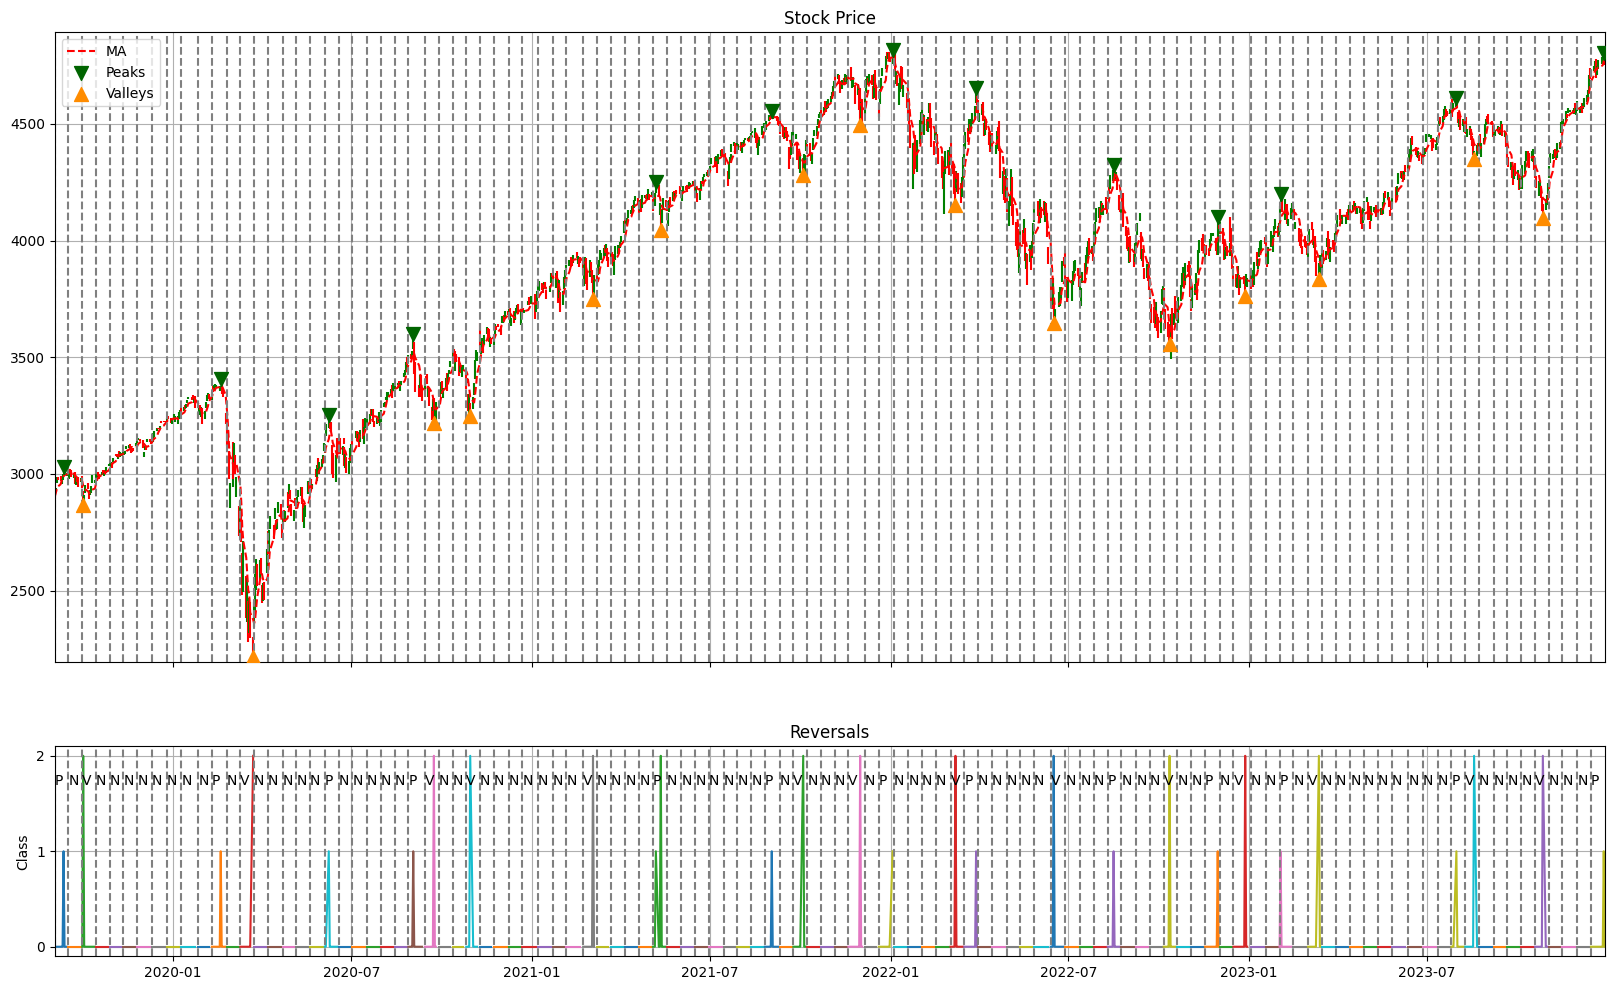

In [228]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
    evaluator._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
ax[0].plot(test_dataset['MA'].loc[test_dates[0][0]: test_dates[-1][-1]], label='MA', color='red', linestyle='--')

peaks_labeled = False
valleys_labeled = False
reversal_type = evaluator.params["features_params"][0]["local_type"]
for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
    if test_dataset['Reversals'].loc[idx] == 1:
        ax[0].scatter(idx, test_dataset.loc[idx][reversal_type]+20, color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
        peaks_labeled = True
    elif test_dataset['Reversals'].loc[idx] == 2:
        ax[0].scatter(idx, test_dataset.loc[idx][reversal_type]-20, color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
        valleys_labeled = True
    
    
# buy_labeled = False
# sell_labeled = False 
# for info in sell_points:
#     if info[0] is not None and info[1] is not None:
#         ax[0].scatter(info[1], info[0]+50, color='black', zorder=10, marker='v', s=200, label='Sell' if sell_labeled == False else '')
#         sell_labeled = True
        
# for info in buy_points:
#     if info[0] is not None and info[1] is not None:
#         ax[0].scatter(info[1], info[0]-50, color='black', zorder=10, marker='^', s=200, label='Buy' if buy_labeled == False else '')
#         buy_labeled = True
        
ax[0].set_title('Stock Price')
ax[0].grid(True)
ax[0].legend()

y_test_label = evaluator._change_labels(y_test_max_indices, abbreviation=True)

for idx in range(test_dates.shape[0]):
    ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
    ax[0].axvline(x=test_dates[idx][0], color='gray', linestyle='--')
    ax[1].axvline(x=test_dates[idx][0], color='gray', linestyle='--')
    ax[1].annotate(f"{y_test_label[idx]}", (test_dates[idx][0], 1.7), label='actual')
ax[1].set_title('Reversals')
ax[1].set_ylabel('Class')
ax[1].set_yticks([0, 1, 2])
ax[1].grid(True)


start = 0
stop = -1
ax[0].set_xlim(test_dates[start][0], test_dates[stop][-1])
ax[0].set_ylim(0.98*test_dataset.loc[test_dates[start][0]: test_dates[stop][-1]][reversal_type].min(), 1.02*test_dataset.loc[test_dates[start][0]: test_dates[stop][-1]][reversal_type].max())

In [229]:
y_test_label

array(['P', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'N',
       'V', 'N', 'N', 'N', 'N', 'N', 'P', 'N', 'N', 'N', 'N', 'N', 'P',
       'V', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N',
       'N', 'N', 'N', 'P', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'N',
       'V', 'N', 'N', 'N', 'V', 'N', 'P', 'N', 'N', 'N', 'N', 'V', 'P',
       'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'P', 'N', 'N', 'N',
       'V', 'N', 'N', 'P', 'N', 'V', 'N', 'N', 'P', 'N', 'V', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'V', 'N', 'N', 'N', 'N',
       'V', 'N', 'N', 'N', 'P'], dtype='<U21')

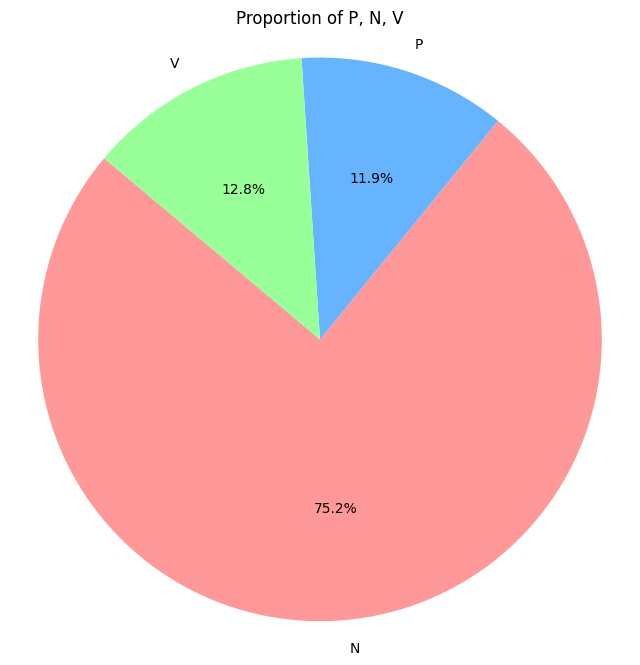

In [231]:
import numpy as np
import matplotlib.pyplot as plt

# 給定的陣列
data = y_test_label

# 計算每個字符的出現次數
values, counts = np.unique(data, return_counts=True)

# 計算比例
total_counts = counts.sum()
proportions = counts / total_counts

# 繪製圓餅圖
plt.figure(figsize=(8, 8))
plt.pie(proportions, labels=values, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Proportion of P, N, V')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [ ]:
# for i in range(test_dates.shape[0]):
#     fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

#     for idx in test_dataset.loc[test_dates[i][0]: test_dates[i][-1]].index:
#         evaluator._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
#         if test_dataset['Reversals'].loc[idx] == 1:
#             ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
#             peaks_labeled = True
#         elif test_dataset['Reversals'].loc[idx] == 2:
#             ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
#             valleys_labeled = True
            
#     ax[0].plot(test_dataset['MA'].loc[test_dates[i][0]: test_dates[i][-1]], label='MA', color='red', linestyle='--')

#     for idx in range(i, i+1):
#         ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
#         ax[0].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
#         ax[1].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
        
#     for info in sell_points[i:i+1]:
#         if info[0] is not None and info[1] is not None:
#             ax[0].scatter(info[1], info[0], color='black', label='Sell', zorder=10, marker='v', s=200)
            
#     for info in buy_points[i:i+1]:
#         if info[0] is not None and info[1] is not None:
#             ax[0].scatter(info[1], info[0], color='black', label='Buy', zorder=10, marker='^', s=200)
#     plt.show()

In [ ]:
# for i in range(1, test_dates.shape[0]-1):
#     fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

#     for idx in test_dataset.loc[test_dates[i-1][0]: test_dates[i+1][-1]].index:
#         evaluator._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
#         if test_dataset['Reversals'].loc[idx] == 1:
#             ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
#             peaks_labeled = True
#         elif test_dataset['Reversals'].loc[idx] == 2:
#             ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
#             valleys_labeled = True
            
#     ax[0].plot(test_dataset['MA'].loc[test_dates[i-1][0]: test_dates[i+1][-1]], label='MA', color='red', linestyle='--')

#     for idx in range(i, i+1):
#         ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
#         ax[0].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
#         ax[1].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
        
#         ax[0].axvline(x=test_dates[idx+1][0], color='lightgray', linestyle='--')
#         ax[1].axvline(x=test_dates[idx+1][0], color='lightgray', linestyle='--')
        
#     for info in sell_points[i:i+1]:
#         if info[0] is not None and info[1] is not None:
#             ax[0].scatter(info[1], info[0], color='black', label='Sell', zorder=10, marker='v', s=200)
            
#     for info in buy_points[i:i+1]:
#         if info[0] is not None and info[1] is not None:
#             ax[0].scatter(info[1], info[0], color='blue', label='Buy', zorder=10, marker='^', s=200)
#     plt.show()